# Training an AutoEncoder with the MNIST dataset

In this notebook, I will be training an AutoEncoder with the MNIST dataset. The AutoEncoder will just take the images and try to reconstruct them. With this, we can see and train the model to learn features from the images. 

In [1]:
"""
author: @cesarasa

Checking the behavior of an autoencoder with the MNIST dataset. 

The autoencoder will be done with a Convolutional Neural Network (CNN) and the
dataset will be loaded using the torchvision library.
"""

import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from sklearn.manifold import TSNE
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader, random_split

# Check the available devices (mps is to train on multiple GPUs, or in M1 Macs)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
device

device(type='cuda')

## Loading the data:

The MNIST dataset is available in the `torchvision` library. We can load the dataset using the `torchvision.datasets.MNIST` class. The dataset contains images of size 28x28. We will normalize the images and convert them to tensors. Then, we will use the `DataLoader` class to create batches of data.

In [7]:
"""

"""
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Split train into train and validation
train_data, val_data = random_split(train_data, [50000, 10000])

# Data Loaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Model Building and Training:

In the following steps, I will be building the AutoEncoder model. For this, we have two classes: the `Encoder` and the `Decoder`. The `Encoder` class will take the input image and encode it to a lower dimension. The `Decoder` class will take the encoded image and decode it to the original image. The `AutoEncoder` class will combine the `Encoder` and `Decoder` classes.

Note that afterwards, if we call an intance of the `AutoEncoder` class, and we use `model.encoder` or `model.decoder`, we will get the `Encoder` and `Decoder` instances respectively. We will train it following: 

- We will use the Mean Squared Error loss function.
- We will use the Adam optimizer.
- We will train the model for 150 epochs. In the laboratory computer, it takes roughly 12 seconds per epoch. Thus, the training will take around 12s * 150 epochs = 1800 s = 30 minutes.
- In my personal Mac M1 Max, it takes roughly 18 seconds per epoch. Thus, the training will take 18s * 150 epocs = 2700 s = 45 minutes. 
- After training, we will plot the loss curve for training and validation data.
- We will also plot some images and their reconstructions.

Questions: How can we improve this? Can we build an even lossier compression that is able to achieve these results? Is it better to use a Denoising AutoEncoder? 

In [8]:


# Define the model

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 32,
                               kernel_size = 5, 
                               padding = 2)
        self.conv2 = nn.Conv2d(in_channels =32,
                               out_channels = 16,
                               kernel_size = 5,
                               padding=2)
        self.conv3 = nn.Conv2d(in_channels = 16,
                                out_channels = 16,
                                kernel_size = 5,
                                padding=2)
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = x.view(-1, 16*3*3)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.t_conv1 = nn.ConvTranspose2d(in_channels = 16,
                                            out_channels = 16,
                                            kernel_size = 5,
                                            stride = 2,
                                            padding = 1)
        self.t_conv2 = nn.ConvTranspose2d(in_channels = 16,
                                            out_channels = 16,
                                            kernel_size = 3,
                                            stride = 2,
                                            padding = 1,
                                            output_padding = 1)
        self.t_conv3 = nn.ConvTranspose2d(in_channels = 16,
                                            out_channels = 1,
                                            kernel_size = 3,
                                            stride = 2,
                                            padding = 1,
                                            output_padding = 1)
        
    def forward(self, x):
        x = x.view(-1, 16, 3, 3)
        x = self.t_conv1(x)
        x = self.t_conv2(x)
        x = self.t_conv3(x)

        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Check a forward pass
model = Autoencoder()
model.to(device)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# Training the model
n_epochs = 150
train_losses = []
val_losses = []
for epoch in range(n_epochs):
    t1 = time.time()
    train_loss = 0.0
    val_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        for data in val_loader:
            images, _ = data
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
    t2 =time.time() - t1
    print(f'[Epoch {epoch+1}/{n_epochs}] -> Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Time: {t2:.2f} s')
    

# Save the model:
torch.save(model.state_dict(), 'mnist_autoencoder.pth')


[Epoch 1/150] -> Train Loss: 0.508857, Val Loss: 0.309962, Time: 18.06 s
[Epoch 2/150] -> Train Loss: 0.275698, Val Loss: 0.257614, Time: 16.12 s
[Epoch 3/150] -> Train Loss: 0.251806, Val Loss: 0.247644, Time: 16.03 s
[Epoch 4/150] -> Train Loss: 0.243433, Val Loss: 0.244189, Time: 15.72 s
[Epoch 5/150] -> Train Loss: 0.238352, Val Loss: 0.238468, Time: 15.87 s
[Epoch 6/150] -> Train Loss: 0.235432, Val Loss: 0.235229, Time: 16.02 s
[Epoch 7/150] -> Train Loss: 0.232720, Val Loss: 0.230779, Time: 15.55 s
[Epoch 8/150] -> Train Loss: 0.230728, Val Loss: 0.229140, Time: 15.44 s
[Epoch 9/150] -> Train Loss: 0.229076, Val Loss: 0.229433, Time: 15.57 s
[Epoch 10/150] -> Train Loss: 0.227709, Val Loss: 0.225418, Time: 15.80 s
[Epoch 11/150] -> Train Loss: 0.226439, Val Loss: 0.225766, Time: 15.73 s
[Epoch 12/150] -> Train Loss: 0.225424, Val Loss: 0.224251, Time: 15.68 s
[Epoch 13/150] -> Train Loss: 0.224521, Val Loss: 0.222634, Time: 15.49 s
[Epoch 14/150] -> Train Loss: 0.223700, Val Los

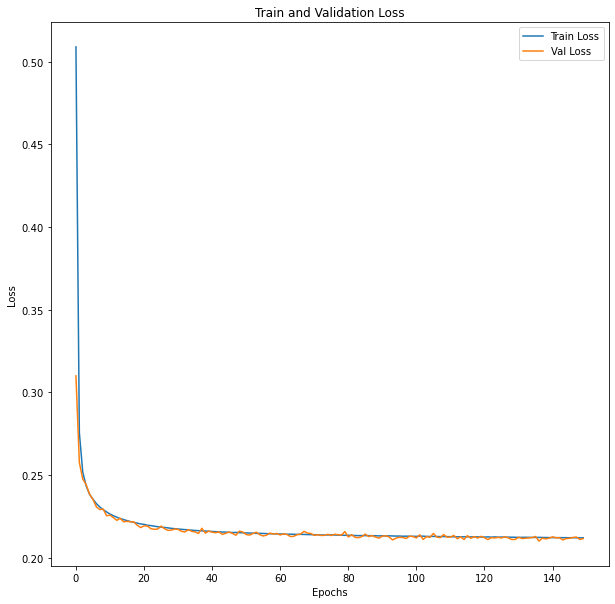

In [9]:
plt.figure(figsize=(10,10))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.show()

### Code to check the model architecture

In PyTorch, when we are building a model, we need to be careful with the size and shape of each one of the layers. In my personal case, I usually confirm layer sizes by printing the shape of the output of each layer. This is a good practice to avoid errors.

In the following cell, I do this for each layer of the autoencoder, ensuring that the shapes are correct. This allows me to do a sanity check on the model architecture.

In [10]:
# Take one batch of images
dataiter = iter(test_loader)
# Pass the batches through convolutional layer
images, labels = next(dataiter)
conv1 = nn.Conv2d(in_channels = 1,
                    out_channels = 16,
                    kernel_size = 5,
                    padding = 2) 
x = conv1(images)               # (batch_size, number_of_filters, height, width)
maxpool = nn.MaxPool2d(2, 2)
x = maxpool(x)                  # This will reduce by half the height and width (it floors the division)
conv2 = nn.Conv2d(in_channels = 16,
                    out_channels = 16,
                    kernel_size = 5,
                    padding = 2)
x = conv2(x)                    # (batch_size, number_of_filters, height, width) Preserves the output of maxpool
x = maxpool(x)                  # This will reduce by half the height and width (it floors the division)
conv3 = nn.Conv2d(in_channels = 16,
                    out_channels = 16,
                    kernel_size = 5,
                    padding = 2)
x = conv3(x)                    # (batch_size, number_of_filters, height, width) Preserves the output of maxpool
x = maxpool(x)                  # This will reduce by half the height and width (it floors the division)
x = x.view(-1, 16*3*3)          # Flatten the tensor

# # # Now we need to pass the tensor through the decoder
t_conv = nn.ConvTranspose2d(in_channels = 16,
                            out_channels = 16,
                            kernel_size = 5,
                            stride = 2,
                            padding = 1)
x = x.view(-1, 16, 3, 3)
x = t_conv(x)
t_conv2 = nn.ConvTranspose2d(in_channels = 16,
                             out_channels = 16,
                            kernel_size = 3,
                            stride = 2,
                            padding = 1,
                            output_padding = 1)
x = t_conv2(x)
t = nn.ConvTranspose2d(in_channels = 16,
                          out_channels = 1,
                          kernel_size = 3,
                          stride = 2,
                          padding = 1,
                          output_padding = 1)
x = t(x)
x.shape

torch.Size([32, 1, 28, 28])

### Showing how the untrained model predicts an image:

The untrained model will predict just noise, as it has not been trained yet. In the following cell we can see the output of the random model that we used for sanity check.

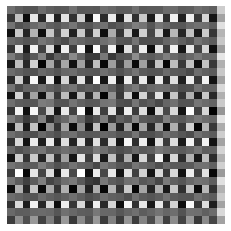

In [11]:
plt.imshow(x[0].reshape(28,28).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

### One image:

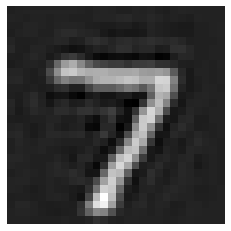

In [12]:
# Take one batch of images
dataiter = iter(test_loader)
# Pass the batches through convolutional layer
images, labels = next(dataiter)
# Pass through model 1 image
image = images[0].to(device)
output = model(image.unsqueeze(0))
output = output.cpu().detach()
output = output.view(28,28)
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()


## Checking the Predictions:

We can see that the model is able to reconstruct the image, in the following cell, we can see the original and the reconstructed images. In the first row, we have the original, whereas in the second row we have the reconstructed images. 

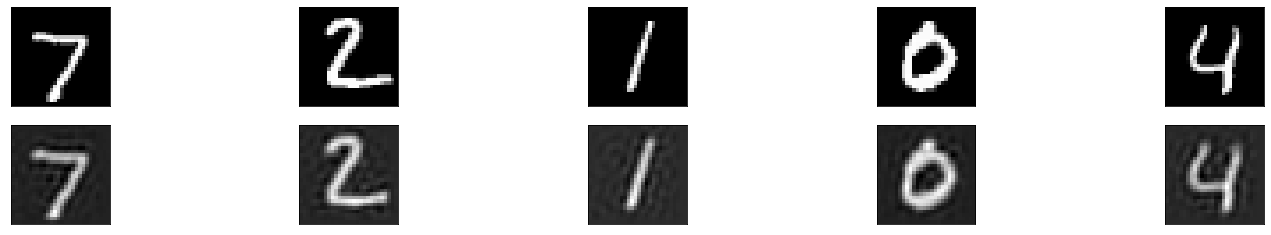

In [13]:
# In the First Batch, check 5 images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images[:5].to(device)
output = model(images)
output = output.cpu().detach()
output = output.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(25,4))
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.view(28, 28).cpu(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Encoding the Images of the test set with the trained encoder

In the following cell, we will save the encoded images of the test set. We will use these encoded images to train a classifier in the future.

In [14]:
# We need to pass all the images through the encoder to get the latent space representation
encoded_images = []
labels = []
with torch.no_grad():
    for data in test_loader:
        images, label = data
        images = images.to(device)
        encoded = model.encoder(images)
        encoded_images.append(encoded)
        labels.append(label)
encoded_images = torch.cat(encoded_images, dim=0)
labels = torch.cat(labels, dim=0)
df = pd.DataFrame(encoded_images.cpu().detach().numpy())
df['labels'] = labels.cpu().detach().numpy()
df.to_csv('encoded_images.csv', index=False)


### Low Dimensional Representation of the Images

We will plot the images using t-Stochastic Neighbour Embedding (t-SNE). This will allow us to see the low-dimensional representation of the images, we will apply it initially to the 144-dimensional representation of the images obtained from the encoder, and then we will do it with the full 28*28-dimensional representation of the images.

/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


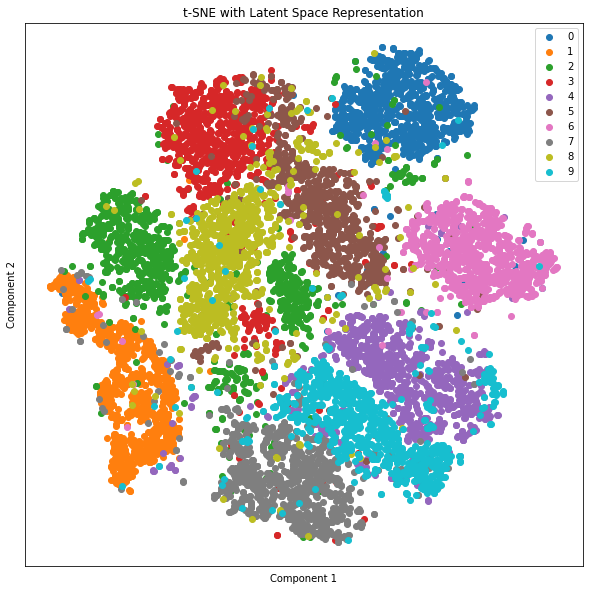

In [15]:
# Latent Space Visualization
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(encoded_images.cpu().detach().numpy())

plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(X_2d[labels==i, 0], X_2d[labels==i, 1], label=str(i))
plt.legend()
plt.title('t-SNE with Latent Space Representation')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
# Take off axis ticks
plt.xticks([])
plt.yticks([])
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/tsne_latent_space_MNIST.png')
plt.show()


/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


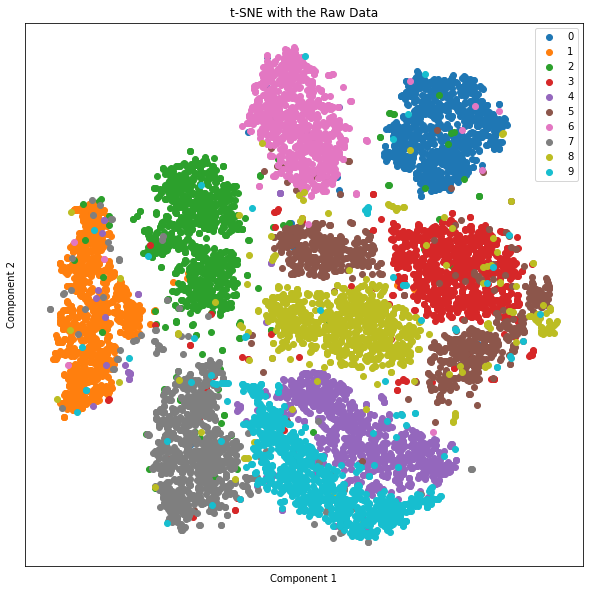

In [16]:
# Labels without the encoding: 
plt.figure(figsize=(10,10))
tsne2 = TSNE(n_components=2, random_state=0)
X_2d2 = tsne2.fit_transform(test_data.data.reshape(-1, 28*28))
for i in range(10):
    plt.scatter(X_2d2[labels==i, 0], X_2d2[labels==i, 1], label=str(i))
plt.legend()
plt.title('t-SNE with the Raw Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.xticks([])
plt.yticks([])
plt.savefig('figures/tsne_raw_data_MNIST.png')
plt.show()

### Final Remarks

As can be seen, the vanilla AutoEncoder is providing a lossy compression of the images, although the images are still recognizable and the latent representation is still useful for classification tasks. However, there is a big overlap between the 4, 7 and 9 classes, whereas with the full images we can see these classes to be really close, but still separated. This might cause some problems with the classification task: for example, we could expect the model to classify a 4 as a 9, or a 7 as a 9.

However, it is important to note that also t-SNE is a non-linear dimensionality reduction technique, and it is not perfect. It is possible that the latent representation is still useful for classification tasks, even though the t-SNE plot shows a big overlap between the classes.

Finally, I would like to show how to use torchsummary to check the model architecture. This is a very useful tool, and it is very easy to use.

In [17]:
print(summary(model.encoder, (1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]          12,816
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Conv2d-5             [-1, 16, 7, 7]           6,416
         MaxPool2d-6             [-1, 16, 3, 3]               0
Total params: 20,064
Trainable params: 20,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 0.08
Estimated Total Size (MB): 0.36
----------------------------------------------------------------
None


/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/modules/conv.py:459: UserWarning: The operator 'aten::_slow_conv2d_forward' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return F.conv2d(input, weight, bias, self.stride,
